<a href="https://colab.research.google.com/github/ddovidovich/DataScienceLerning/blob/main/UNIT_14_DZ_Ultra_Pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Давайте немного отвлечемся от тяжелых будней будущего нейронщика и вспомним, что в мире есть маленькие радости - а именно мультяшки. 

В этой работе: 
- скачайте датасет от Гугла с мультяшными персонажами. Ссылка: https://storage.yandexcloud.net/aiueducation/Content/advanced/l1/cartoonset10k.zip
- обучите VAE на данном датасете
- посмотрите качество воспроизведения мультяшек
- нагенерите мультяшек на свой вкус - оцените работу декодера

In [1]:
# Импортируем TensorFlow
import tensorflow as tf

# Импортируем Keras
import keras

# Подключим Numpy
import numpy as np

# Подключим библиотеку отображения графиков
import matplotlib.pyplot as plt

# Импортируем Keras
from tensorflow import keras

# Подключим все необходимые слои Keras
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Lambda, LeakyReLU
from tensorflow.keras.layers import BatchNormalization, Dropout, concatenate, Conv2D, Conv2DTranspose
from tensorflow.keras import layers

# Подключим модуль вычислений на Keras
import keras.backend as K

# загрузка файлов по HTML ссылке
import gdown

# Подключим модуль работы с операционной системой
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # От tensorflow будет получать только ошибки

In [2]:
# Загрузка датасета из облака

gdown.download('https://storage.yandexcloud.net/aiueducation/Content/advanced/l1/cartoonset10k.zip', None, quiet=False)

Downloading...
From: https://storage.yandexcloud.net/aiueducation/Content/advanced/l1/cartoonset10k.zip
To: /content/cartoonset10k.zip
100%|██████████| 479M/479M [00:49<00:00, 9.76MB/s]


'cartoonset10k.zip'

In [3]:
# Распаковка архива на локальный диск colab
!unzip -qo cartoonset10k.zip -d cartoonset10k/

In [4]:
img_height, img_width = 256, 256  # Определим размер изображений
batch_size = 128                  # Зададим размер батча
hidden_dim = 200                  # Зададим размер скрытого пространства

In [5]:
# Из набора изображений соберем датасет

train_ds = tf.keras.preprocessing.image_dataset_from_directory(  
  'cartoonset10k/',                                              # Папка с файлами - изображениями
  image_size=(img_height, img_width),                            # Размер изображения
  batch_size=batch_size,                                         # Размер батча
  label_mode=None)                                               # Метки не используем

Found 10000 files belonging to 1 classes.


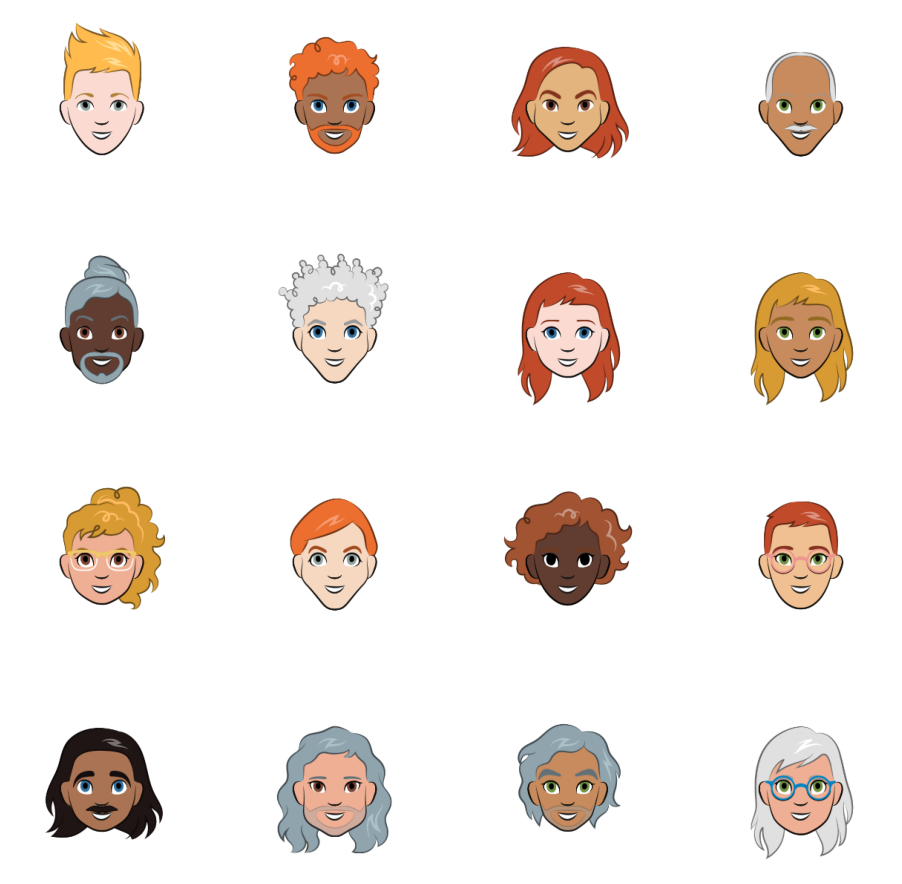

In [6]:
plt.figure(figsize=(16, 16))                          # Установим размер изображения
for images in train_ds.take(1):                       # Возьмем первый батч
    for i in range(16):                               # Цикл по 16 изображениям
        ax = plt.subplot(4, 4, i + 1)                 # Определим i-е место для изображения
        plt.imshow(images[i].numpy().astype("uint8")) # Отрисуем i-е изображение 
        plt.axis("off")                               # Спрячем ось Х

In [7]:
normalization_layer = layers.experimental.preprocessing.Rescaling(scale= 1./255) # Создадим слой для масштабирования изображений
normalized_ds = train_ds.map(lambda x: normalization_layer(x))  #  Погоним датасет через масштабирующий слой

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [8]:
input_encoder = (256, 256, 3) # Зададим вход энкодера
input_decoder = (hidden_dim,) # Зададим вход декодера

In [11]:
# Создадим функцию сборки блока построения сверточного энкодера

def encoderBlock(xin,        # Входной тензор
                 neu=8,      # Число нейроной сверточного слоя
                 kernel=3,   # Размер ядра сверточного слоя
                 strides=1,  # Число шагом сверточного слоя
                 index = 0): 

    # Составим блок сети
    x = Conv2D(neu, kernel_size=kernel, strides= strides, padding='same')(xin) # Добавим 2D свертку
    if index>0:
      x = BatchNormalization(name='eB_bn_'+str(index))(x)   # Добавим нормализацию по батчу
      x = LeakyReLU(name='eB_lrelu_'+str(index))(x)         # Добавим функцию активации
    else:
      x = BatchNormalization()(x)                   # Добавим нормализацию по батчу
      x = LeakyReLU()(x)                            # Добавим функцию активации        
    # Вернем выходной тензор
    return x


In [12]:
# Создадим функцию сборки блока построения сверточного декодера

def decoderBlock(xin,        # Входной тензор
                 neu=8,      # Число нейроной сверточного слоя
                 kernel=3,   # Размер ядра сверточного слоя
                 strides=1,  # Число шагом сверточного слоя
                 index = 0): 

    # Составим блок сети
    x = Conv2DTranspose(neu, kernel_size=kernel, strides= strides, padding='same')(xin)  # Добавим обратную 2D свертку
    if index>0:
      x = BatchNormalization(name='dB_bn_'+str(index))(x)   # Добавим нормализацию по батчу
      x = LeakyReLU(name='dB_lrelu_'+str(index))(x)         # Добавим функцию активации
    else:
      x = BatchNormalization()(x)                   # Добавим нормализацию по батчу
      x = LeakyReLU()(x)                                                                     # Добавим функцию активации

    # Вернем выходной тензор
    return x

In [36]:
# Создадим сверточный энкодер
encoder_inputs = Input(input_encoder)                                               # Добавим входной слой
x = encoderBlock(encoder_inputs, neu=32, kernel=3, strides=2, index=1)              # Добавим 1-й блок свертка+нормализация+активашка
x = encoderBlock(x, neu=64, kernel=3, strides=2, index=2)                           # Добавим 2-й блок свертка+нормализация+активашка
x = encoderBlock(x, neu=64, kernel=3, strides=2, index=3)                           # Добавим 3-й блок свертка+нормализация+активашка
x = encoderBlock(x, neu=64, kernel=3, strides=2, index=4)                           # Добавим 4-й блок свертка+нормализация+активашка
x = encoderBlock(x, neu=64, kernel=3, strides=2, index=5)                           # Добавим 5-й блок свертка+нормализация+активашка
x = layers.Flatten()(x)                                                             # Добавим Flatten

In [37]:
z_mean = Dense(hidden_dim)(x)       # Добавим dense для получения мат.ожидания
z_log_var = Dense(hidden_dim)(x)    # Добавим dense для получения логарифма дисперсии

In [38]:
# Создадим функцию - генератор случайных чисел с заданными параметрами

def noiser(args):                                                          # Входные параметры
  z_mean, z_log_var = args                                                 # Разберем входные параметры на отдельные переменные
  N = K.random_normal(shape=(K.shape(z_mean)[0], hidden_dim), mean=0., stddev=1.0) # Генерируем тензор из нормальных случайных  чисел с параметрами (0,1)

  # Вернем тензор случайных числел с заданной дисперсией и мат.ожиданием
  return K.exp(z_log_var / 2) * N + z_mean                                 

h = Lambda(noiser, output_shape=(hidden_dim,))([z_mean, z_log_var])       # Создадим свой слой - лямбда. На входе мат.ожидание и логарифм дисперсии 
                                                                          # На выходе - тензор случайных чисел

In [39]:
# Соберем энкодер
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, h], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 128, 128, 32  896         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 eB_bn_1 (BatchNormalization)   (None, 128, 128, 32  128         ['conv2d_10[0][0]']              
                                )                                                           

In [41]:
#  Создадим декодер

input_dec = keras.Input(shape=(hidden_dim,), name='input_layer')  # Добавим входной слой
x = Dense(4096, name='dense_1')(input_dec)                        # Добавим dense слой
x = Reshape((8,8,64), name='Reshape')(x)                          # Выполним решейп 4096 = 8х8х64
x = decoderBlock(x, neu=64, kernel=3, strides=2, index=1)         # Добавим 1-й блок обратная свертка+нормализация+активашка
x = decoderBlock(x, neu=64, kernel=3, strides=2, index=2)         # Добавим 2-й блок обратная свертка+нормализация+активашка
x = decoderBlock(x, neu=64, kernel=3, strides=2, index=3)         # Добавим 3-й блок обратная свертка+нормализация+активашка
x = decoderBlock(x, neu=32, kernel=3, strides=2, index=5)         # Добавим 4-й блок обратная свертка+нормализация+активашка

decoded = Conv2DTranspose(3, 3, 2,padding='same', activation='sigmoid', name='conv_transpose_5')(x) # Добавим выходной слой

decoder = tf.keras.Model(input_dec, decoded, name="Decoder")
decoder.summary() 

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200)]             0         
                                                                 
 dense_1 (Dense)             (None, 4096)              823296    
                                                                 
 Reshape (Reshape)           (None, 8, 8, 64)          0         
                                                                 
 conv2d_transpose_10 (Conv2D  (None, 16, 16, 64)       36928     
 Transpose)                                                      
                                                                 
 dB_bn_1 (BatchNormalization  (None, 16, 16, 64)       256       
 )                                                               
                                                                 
 dB_lrelu_1 (LeakyReLU)      (None, 16, 16, 64)        0   

In [42]:
out = decoder(encoder(encoder_inputs)[2])        # Получим выражение для выхода декодера
cart  = keras.Model(encoder_inputs, out) # Соберем сеть автокодировщика

In [43]:
reconstruction_loss = keras.losses.MSE(encoder_inputs,out)          # Рассчитаем ошибку восстановления изображения - лоссы MSE
reconstruction_loss *= 1000                                  # Уберем нормировку MSE
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)      # Рассчитаем лоссы KL
kl_loss = -0.5* K.sum(kl_loss, axis=-1)                      #  
cart_loss = K.mean(reconstruction_loss) +  K.mean(kl_loss)   # Суммируем лоссы - здесь можно вводить веса  
cart.add_loss(cart_loss)                                     # Отдадим наш лосс VAE

In [44]:
cart.compile(optimizer='adam') # Компилируем модель, оптимайзер ADAM

In [45]:
# Запускаем обучениe

history = cart.fit(normalized_ds, # Обучающая выборка
        epochs=20,      # 20 эпох
        shuffle=True)   # обучающую выборку перемешиваем

Epoch 1/20
79/79 [==============================] - 59s 601ms/step - loss: 117.4310
Epoch 2/20
79/79 [==============================] - 54s 625ms/step - loss: 35.6871
Epoch 3/20
79/79 [==============================] - 51s 596ms/step - loss: 28.0618
Epoch 4/20
79/79 [==============================] - 52s 599ms/step - loss: 25.9693
Epoch 5/20
79/79 [==============================] - 50s 587ms/step - loss: 24.3543
Epoch 6/20
79/79 [==============================] - 52s 605ms/step - loss: 22.4976
Epoch 7/20
79/79 [==============================] - 53s 623ms/step - loss: 21.3340
Epoch 8/20
79/79 [==============================] - 52s 609ms/step - loss: 20.6950
Epoch 9/20
79/79 [==============================] - 52s 617ms/step - loss: 20.2283
Epoch 10/20
79/79 [==============================] - 53s 606ms/step - loss: 19.8990
Epoch 11/20
79/79 [==============================] - 51s 605ms/step - loss: 19.6230
Epoch 12/20
79/79 [==============================] - 51s 596ms/step - loss: 19.6252


In [46]:
# Определим функцию отображения 25 картинок

def showResult(re): # Получим 25 картинок
    
    total = 5                               # Считаем полное количесво выводимых мультяшек +1
    plt.figure(figsize=(total, total))       # Создаем заготовку для финальной картинки 10x10
    num = 1                                  # Счетчик выводимых мультяшек
    for i in range(25):                     # Цикл по картинкам
        ax = plt.subplot(total, total, num)  # Добавим место для графика
        img = re[num-1:num,:,:,:]            # Сформируем очередную картинку
        num += 1                             # Инкремент номера графика        
        plt.imshow(img.squeeze())            # Рисуем пмультяшек
        ax.get_xaxis().set_visible(False)    # Спрячем ось X
        ax.get_yaxis().set_visible(False)    # Спрячем ось Y

1/1 [==============================] - 1s 625ms/step


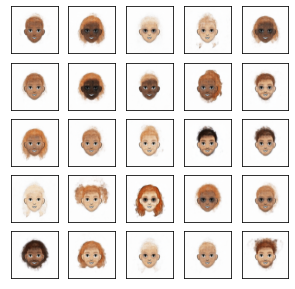

In [47]:
# Проверим воспроизведение автокодировщиком картинок
image_batch = next(iter(normalized_ds))
x = cart.predict(image_batch[:25,:,:,:])      # Выполним предикт 25 картинок полным автокодировщиком
showResult(x)                                 # Выведем полученные результаты

1/1 [==============================] - 0s 154ms/step


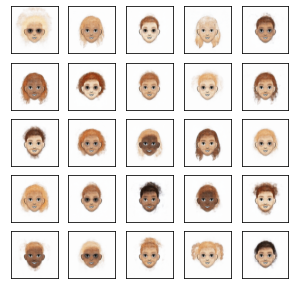

In [48]:
# Проверим работу декодера

x = np.random.normal(size = (25,hidden_dim)) # Выполним генерациии 100 точек скрытого пространсва
reconstruct = decoder.predict(x)             # Выполним предикт 100 картинок декодером
showResult(reconstruct)                      # Выведем полученные результаты